<a href="https://colab.research.google.com/github/irohan98/Dance-Form-Classifier/blob/master/Dance_Form_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
print(tf.__version__)

2.3.0


# Mount Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/My Drive/Dance_classifier/dataset

/content/drive/My Drive/Dance_classifier/dataset


# Dataset Exploration

## Images in the Dataset

In [17]:
import matplotlib.pyplot as plt
import os
import cv2

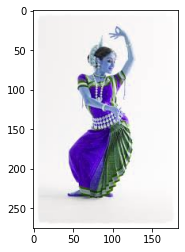

[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]
----------------------
(275, 183, 3)


In [21]:
DATADIR = '/content/drive/My Drive/Dance_classifier/dataset'   #add path after appending the drive
CATEGORIES = ['train','test']
for category in CATEGORIES:
  path = os.path.join(DATADIR, category)
  for img in os.listdir(path):
    img_array = cv2.imread(os.path.join(path,img))
    plt.imshow(img_array)
    plt.show()
    break
  break

print(img_array)
print("----------------------")
print(img_array.shape)

##Training Set
Train.csv files

In [4]:
import pandas as pd

In [5]:
train = pd.read_csv('/content/drive/My Drive/Dance_classifier/dataset/train.csv')
train.Image = train.Image.astype('str')
train.target = train.target.astype('str')

In [6]:
train.head()

,Image,target
0,96.jpg,manipuri
1,163.jpg,bharatanatyam
2,450.jpg,odissi
3,219.jpg,kathakali
4,455.jpg,odissi


In [7]:
print(train.columns)
print(len(train))

Index(['Image', 'target'], dtype='object')
364


In [8]:
train['target'].value_counts()

mohiniyattam     50
odissi           49
kathakali        47
bharatanatyam    47
kuchipudi        46
sattriya         45
kathak           44
manipuri         36
Name: target, dtype: int64

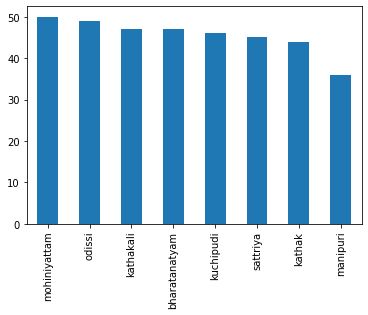

In [9]:
train['target'].value_counts().plot(kind='bar')

# Model 1 (New Model)

##Packages

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

##Improving Dataset

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255,
                                  shear_range = 0.2, 
                                  zoom_range = 0.5,
                                  rotation_range = 45,
                                  width_shift_range=0.1,
                                  # randomly shift images vertically (fraction of total height)
                                  height_shift_range=0.1,
                                  horizontal_flip = True)

In [12]:
epochs = 2
batch_size = 32
img_size = [150,150]
train_generator = train_datagen.flow_from_dataframe(dataframe = train,
                                                    directory="/content/drive/My Drive/Dance_classifier/dataset/train", 
                                                    x_col="Image",
                                                    y_col="target",
                                                    class_mode="categorical",
                                                    shuffle = True,
                                                    target_size=img_size,
                                                    batch_size=batch_size)

Found 364 validated image filenames belonging to 8 classes.


In [13]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [15]:
augmented_images = [train_generator[0][0][0] for i in range(5)]

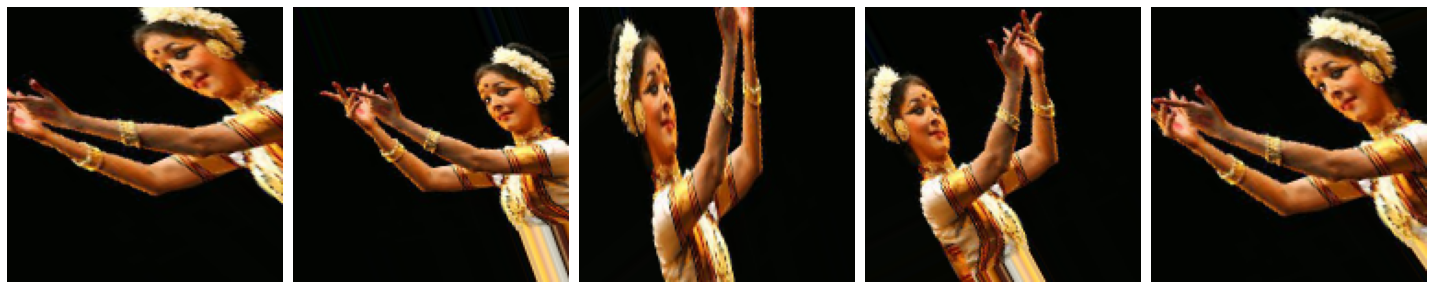

In [16]:
plotImages(augmented_images)

##Model Architecture

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.layers import Flatten, Dense, Dropout, Activation
from tensorflow.keras.callbacks import EarlyStopping
model = Sequential()

In [ ]:
#1st layer
model.add(Conv2D(32, (3,3), activation='relu', input_shape= img_size + [3]))
model.add(Conv2D(32,(3,3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
#2nd layer
model.add(Conv2D(64,(3,3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64,(3,3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.3))
model.add(tf.keras.layers.BatchNormalization())
#Flatten
model.add(Flatten())
#Dense or FC layer
model.add(Dense(128))
#model.add(tf.keras.layers.BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))
#Final Output Layer/ Softmax Layer
model.add(Dense(8))
#model.add(tf.keras.layers.BatchNormalization())
model.add(Activation('softmax'))

opt = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=1e-8)

model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
#You can add more layers and make the architecture much more dense 
#You can also add Batch Normalization and further Normalize your layers
model.summary()

##Tensorboard callback and Training

In [ ]:
import datetime
log_dir = "/content/drive/My Drive/Dance_classifier/dataset/logs/"+datetime.datetime.now().strftime("%Y%m%d")
print(log_dir)

In [ ]:
%cd /content/drive/My Drive/Dance_classifier/dataset

In [ ]:
%load_ext tensorboard

In [ ]:
#Make sure that logs are stored in 'log_dir'
%tensorboard --logdir logs/

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
main = model.fit(train_generator, epochs = epochs, steps_per_epoch= (len(train)/batch_size), initial_epoch = 0, shuffle=True, callbacks=[tensorboard_callback])

####Visualizing Plots using matplot.lib.pyplot

In [ ]:
# Loss
plt.plot(main.history['loss'], label='train loss')
plt.legend()
plt.show()
plt.savefig('Loss_Curve')

# Accuracy
plt.plot(main.history['categorical_accuracy'], label='train acc')
plt.legend()
plt.show()
plt.savefig('Accuracy_Curve')

##Saving the Model

In [ ]:
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'Dance_classifier.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

##Test Set
Test.csv file

In [ ]:
test = pd.read_csv('/content/drive/My Drive/Dance_classifier/dataset/test.csv')

In [ ]:
test.head()

In [ ]:
classes = train_generator.class_indices
print(classes)

In [ ]:
inverted_classes = dict(map(reversed, classes.items()))
print(inverted_classes)

## Loading The Saved Model

In [ ]:
 # Recreate the exact same model, including its weights and the optimizer
model = tf.keras.models.load_model('/content/drive/My Drive/Dance_classifier/dataset/saved_models/Dance_classifier.h5')
# Show the model architecture
model.summary()

In [ ]:
%cd /content/drive/My Drive/Dance_classifier/dataset/test

##Predictions on the Test Set

In [ ]:
from keras.preprocessing import image
y_pred = []
for i in range(len(test)):
  img = image.load_img(path = test.Image[i], target_size = img_size + [3])
  img = image.img_to_array(img)
  test_img = img.reshape([1] + img_size + [3])
  #img_class = model.predict_classes(test_img)
  img_class = np.argmax(model.predict(test_img), axis = -1)
  prediction = img_class[0]
  y_pred.append(prediction)

In [ ]:
print(y_pred)

In [ ]:
prediction_classes = [ inverted_classes.get(item,item) for item in y_pred ]

In [ ]:
print(prediction_classes)

In [ ]:
predictions = {}
predictions['Image'] = test.Image
predictions['target'] = prediction_classes

##Submission

###Converting DataFrame to .CSV file

In [ ]:
df = pd.DataFrame(predictions)
df.to_csv('/content/drive/My Drive/Dance_classifier/dataset/predictionstrial1.csv', index=False) 

###Converting DataFrame to Excel file

In [ ]:
#Writing to excel
pd.DataFrame(predictions).to_excel("/content/drive/My Drive/Dance_classifier/dataset/predictions.xlsx", index = False)

# Model 2 (VGGNet Tranfer Learning approach)

##Packages

In [ ]:
from keras.layers import Input, Lambda, Dense, Flatten, Dropout
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2

Acessing Train.csv file

In [ ]:
train = pd.read_csv('/content/drive/My Drive/Dance_classifier/dataset/train.csv')

In [ ]:
train.head()

Path to Training and Testing Images

In [ ]:
train_path = '/content/drive/My Drive/Dance_classifier/dataset/train'
test_path = '/content/drive/My Drive/Dance_classifier/dataset/test'

In [ ]:
# Resize all the images to this
IMAGE_SIZE = [224, 224]

##Extracting Images and Labels

In [ ]:
images = []
labels = list(train['target'])
for filename in list(train['Image']):
    image = cv2.imread(os.path.join(train_path, filename))
    image = cv2.resize(image, tuple(IMAGE_SIZE))
    image = preprocess_input(image)
    images.append(image)

In [ ]:
images = np.array(images)
labels = np.array(labels)

In [ ]:
labels

Encoding Labels (ONE-HOT Representation)

In [ ]:
lb = LabelEncoder()
labels = lb.fit_transform(labels)
print(labels[:10])
labels = to_categorical(labels)
print(labels[:10])

##Spliting of Train Images into Train and Validation folders

In [ ]:
(trainX, testX, trainY, testY) = train_test_split(images, labels,
                                test_size=0.20, stratify=labels, random_state=42)

In [ ]:
print(len(trainX))
print(len(trainY))
print(len(testX))
print(len(testY))

In [ ]:
testX.shape

##Improving Dataset

In [ ]:
traindata_gen = ImageDataGenerator(
    rescale = 1/255.0,
    rotation_range = 20,
    zoom_range = 0.2,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    fill_mode = 'nearest',
    horizontal_flip = True
)

testdata_gen = ImageDataGenerator(
    rescale = 1/255.0,
    horizontal_flip = True
) 

In [ ]:
def plotimages(img_array):
  fig, axes = plt.subplots(1, 5, sharex='all', sharey= 'all', figsize=(20,20)) 
  axes = axes.flatten() 
  for img, ax in zip(img_array, axes):
    ax.imshow(img)
    ax.set_title('Different Views of the Images') 
    ax.axis('off')
  plt.show()

##Model 2 Architecture

In [ ]:
#add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [ ]:
# Don't train existing weights
for layer in vgg.layers:
    layer.trainable = False

In [ ]:
# Custom layers - You can add more if you want!
x = Flatten()(vgg.output)
x = Dense(1024, activation = 'relu')(x)
x = Dropout(0.20)(x)
prediction = Dense(8, activation='softmax')(x)

In [ ]:
# Create a model object
model = Model(inputs=vgg.input, outputs=prediction)

In [ ]:
# To view the structure of the model
model.summary()

In [ ]:
model.compile(
    loss='categorical_crossentropy',
    optimizer = 'Adam',
    metrics = ['accuracy']
)

In [ ]:
train_generator = traindata_gen.flow(trainX, trainY, shuffle = True, batch_size=32)
test_generator = testdata_gen.flow(testX, testY, batch_size = 32)

In [ ]:
print(len(train_generator))
print(len(trainX)/32)

In [ ]:
augimages = [train_generator[0][0][0] for i in range(5)]
plotimages(augimages)

##Callbacks and Training

In [ ]:
# Set a Learning Rate Annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                           patience=3,
                                           verbose=1,
                                           factor=0.5,
                                           min_lr=0.0001)


In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_images=True)

In [ ]:
import datetime
log_dir = "/content/drive/My Drive/Dance_classifier/dataset/logsVgg/"+datetime.datetime.now().strftime("%Y%m%d")

In [ ]:
%cd /content/drive/My Drive/Dance_classifier/dataset

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir logsVgg/

In [ ]:
main = model.fit(train_generator,
        validation_data = test_generator,
        epochs = 2,
        steps_per_epoch = len(train_generator),
        validation_steps = len(test_generator),
        callbacks = [learning_rate_reduction, tensorboard_callback]
)

###Visualizing plots using Matplotlib.pyplot

In [ ]:
# loss
plt.plot(main.history['loss'], label='train loss')
plt.plot(main.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss1')

# accuracies
plt.plot(main.history['accuracy'], label='train acc')
plt.plot(main.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AvvVal_acc1')

##Save Model

In [ ]:
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'Dance_classifier_vgg.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

##Load Model

In [ ]:
# Recreate the exact same model, including its weights and the optimizer
model = tf.keras.models.load_model('/content/drive/My Drive/Dance_classifier/dataset/saved_models/Dance_classifier_vgg.h5')
# Show the model architecture
model.summary()

##Evaluation on Test Set (Model is evaluated on this set)

In [ ]:
test_df = pd.read_csv('/content/drive/My Drive/Dance_classifier/dataset/test.csv')

In [ ]:
test_df.head()

In [ ]:
test_images = []
for filename in list(test_df['Image']):
    image = cv2.imread(os.path.join(test_path, filename))
    image = cv2.resize(image, tuple(IMAGE_SIZE))
    image = preprocess_input(image)
    test_images.append(image)

In [ ]:
test_images = np.array(test_images)

In [ ]:
test_images.shape

In [ ]:
test_labels = []

In [ ]:
# create test labels 
def create_test_labels():
    for image in test_images:
        image = cv2.resize(image, tuple(IMAGE_SIZE))
        image = image.reshape([-1] + IMAGE_SIZE + [3])
        image = preprocess_input(image)
        predict = model.predict(image)
        test_labels.append([image, predict])

create_test_labels()

In [ ]:
Image = []
target = []
for i, j in test_labels:
    target.append(np.argmax(j))
    Image.append(i)
df = pd.DataFrame(columns=['target'])
df['target'] = target
df['target'] = lb.inverse_transform(df['target'])

In [ ]:
predictions = pd.concat([test_df['Image'], df['target']], axis=1)
predictions.to_csv('/content/drive/My Drive/Dance_classifier/dataset/vggpredictions_6.csv', index=False)

In [ ]:
predictions

##Submission

##Converting DataFrame to .CSV file

In [ ]:
df = pd.DataFrame(predictions)
df.to_csv('/content/drive/My Drive/Dance_classifier/dataset/predictionstrial1.csv', index=False) 

##Converting DataFrame to Excel Format

In [ ]:
#Writing to excel
pd.DataFrame(predictions).to_excel("/content/drive/My Drive/Dance_classifier/dataset/predictions.xlsx", index = False)